**Predictive Maintenance of Hydraulics System**

Number of Attributes: 43680 
(8x60 (1 Hz) + 2x600 (10 Hz) + 7x6000 (100 Hz))

The data set addresses the condition assessment of a hydraulic test rig based on multi sensor data. 

The system cyclically repeats constant load cycles (duration 60 seconds) and measures process values such as pressures, volume flows and temperatures while the condition of four hydraulic components (cooler, valve, pump and accumulator) is quantitatively varied.

The data set contains raw process sensor data (i.e. without feature extraction) which are structured as matrices (tab-delimited) with the rows representing the cycles and the columns the data points within a cycle. The sensors involved are:


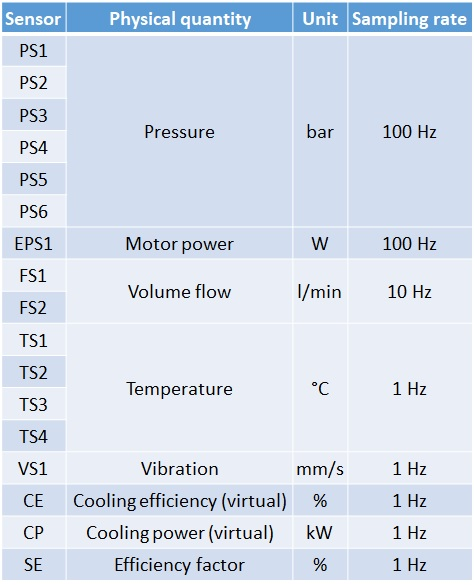

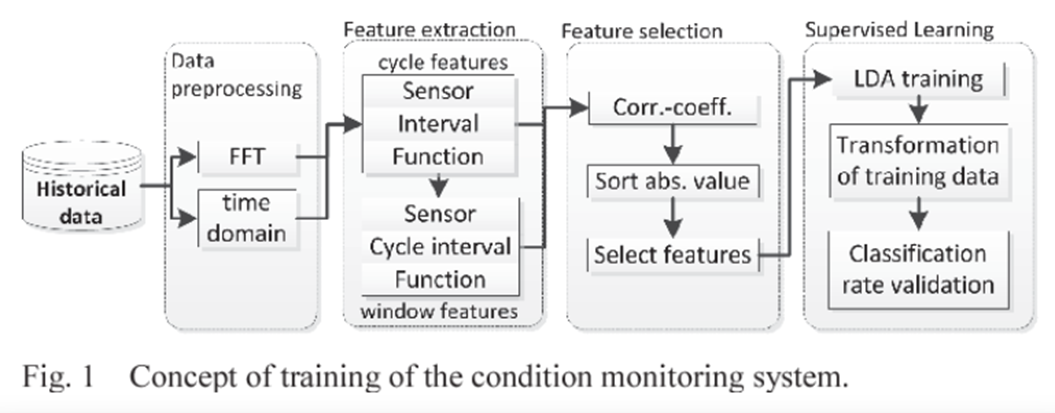

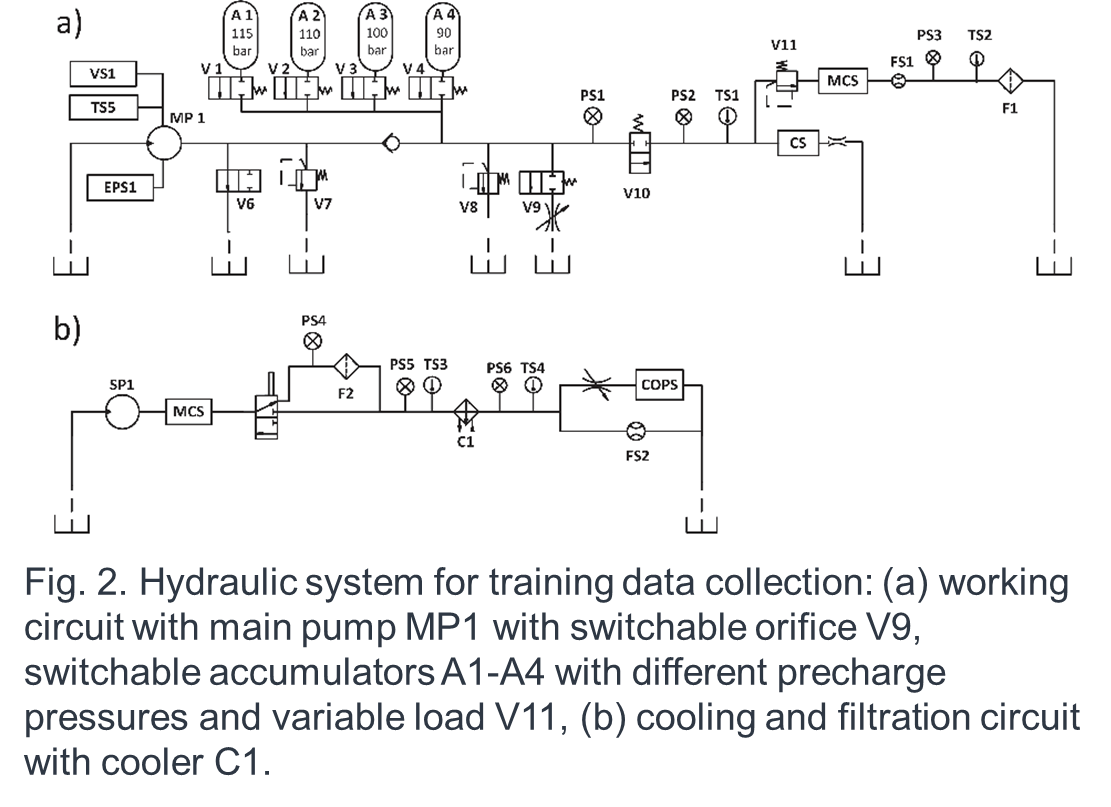

# **Data Description:**

-> 4 assets - cooler, valve, pump, accumulator

-> Thresholds for failure given for each asset

-> Failure points:

    - Cooler < 3
    - Valve < 73
    - Pump = 1, 2
    - Accumulator < 90
    - Overall plant state: 1 (faliure), 0 (stable)

-> Feature overview: pressure, motor power, volume flow, temperature,   vibration, cooling efficiency, cooling power, effciency factor

In [ ]:
!pip install tpot

     |████████████████████████████████| 87 kB 5.5 MB/s 
     |████████████████████████████████| 193.7 MB 38 kB/s 
     |████████████████████████████████| 160 kB 58.2 MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11956 sha256=ef041b45c64172df831635ef96331f0723c3eed8b46859efaba2c6f3ea7b23e1
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score, r2_score
from sklearn.model_selection import cross_validate,GridSearchCV,RandomizedSearchCV
from tpot import TPOTClassifier
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [ ]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00447/data.zip"
!unzip "data.zip"

--2022-05-09 04:51:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/00447/data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76601704 (73M) [application/x-httpd-php]
Saving to: ‘data.zip’

data.zip            100%[===================>]  73.05M  33.5MB/s    in 2.2s    

2022-05-09 04:51:37 (33.5 MB/s) - ‘data.zip’ saved [76601704/76601704]

Archive:  data.zip
  inflating: CE.txt                  
  inflating: CP.txt                  
  inflating: description.txt         
  inflating: EPS1.txt                
  inflating: FS1.txt                 
  inflating: FS2.txt                 
  inflating: profile.txt             
  inflating: PS1.txt                 
  inflating: PS2.txt                 
  inflating: PS3.txt                 
  inflating: PS4.txt                 
  inflating: PS5.txt             

# 1- Data Preperation

In [ ]:
a=[]
for i in ["PS1","PS2","PS3","PS4","PS5","PS6"]:
    PS=np.genfromtxt(r"/content/"+"/"+i+".txt")
    a.append(PS)
ps1,ps2,ps3,ps4,ps5,ps6=a

In [ ]:
ps1_arr=ps1.mean(axis=1)
ps2_arr=ps2.mean(axis=1)
ps3_arr=ps3.mean(axis=1)
ps4_arr=ps4.mean(axis=1)
ps5_arr=ps5.mean(axis=1)
ps6_arr=ps6.mean(axis=1)

In [ ]:
df = pd.DataFrame({"PS1":ps1_arr,"PS2":ps2_arr,"PS3":ps3_arr,"PS4":ps4_arr,"PS5":ps5_arr,"PS6":ps6_arr})

In [ ]:
eps1 = np.genfromtxt(r"/content/EPS1.txt")
esp1_arr=eps1.mean(axis=1)

df["ESP1"]=esp1_arr

In [ ]:
a=[]
for i in ["FS1","FS2"]:
    FS=np.genfromtxt(r"/content"+"/"+i+".txt")
    a.append(FS)
fs1,fs2=a

fs1_arr=fs1.mean(axis=1)
fs2_arr=fs2.mean(axis=1)

df["FS1"]=fs1_arr
df["FS2"]=fs2_arr

In [ ]:
a=[]
for i in ["TS1","TS2","TS3","TS4"]:
    TS=np.genfromtxt(r"/content/"+"/"+i+".txt")
    a.append(TS)
ts1,ts2,ts3,ts4=a

ts1_arr=ts1.mean(axis=1)
ts2_arr=ts2.mean(axis=1)
ts3_arr=ts3.mean(axis=1)
ts4_arr=ts4.mean(axis=1)

df["TS1"]=ts1_arr
df["TS2"]=ts2_arr
df["TS3"]=ts3_arr
df["TS4"]=ts4_arr

In [ ]:
vs1=np.genfromtxt(r"/content/VS1.txt")

vs1_arr=vs1.mean(axis=1)

df["VS1"]=vs1_arr

In [ ]:
a=[]
for i in ["CE","CP"]:
    C=np.genfromtxt(r"/content/"+"/"+i+".txt")
    a.append(C)
ce,cp=a

ce_arr=ce.mean(axis=1)

cp_arr=cp.mean(axis=1)

df["CE"]=ce_arr
df["CP"]=cp_arr

In [ ]:
se=np.genfromtxt(r"/content/SE.txt")

se_arr=se.mean(axis=1)

df["SE"]=se_arr

In [ ]:
target = np.genfromtxt(r"/content/profile.txt")

df_temp=pd.DataFrame(target,columns=["Cooler_Condition","Valve_Condition","Internal_Pump_Leakage","Hydraulic_Accumulator","Stable_Flag"])
df_final=pd.concat([df,df_temp],axis=1)

In [ ]:
df_final.head()

,PS1,PS2,PS3,PS4,PS5,PS6,ESP1,FS1,FS2,TS1,...,TS4,VS1,CE,CP,SE,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator,Stable_Flag
0,160.673492,109.466914,1.991475,0.0,9.842169,9.728098,2538.929167,6.709815,10.304592,35.621983,...,31.745250,0.576950,39.601350,1.862750,59.157183,3.0,100.0,0.0,130.0,1.0
1,160.603320,109.354890,1.976234,0.0,9.635142,9.529488,2531.498900,6.715315,10.403098,36.676967,...,34.493867,0.565850,25.786433,1.255550,59.335617,3.0,100.0,0.0,130.0,1.0
2,160.347720,109.158845,1.972224,0.0,9.530548,9.427949,2519.928000,6.718522,10.366250,37.880800,...,35.646150,0.576533,22.218233,1.113217,59.543150,3.0,100.0,0.0,130.0,1.0
3,160.188088,109.064807,1.946576,0.0,9.438827,9.337429,2511.541633,6.720565,10.302678,38.879050,...,36.579467,0.569267,20.459817,1.062150,59.794900,3.0,100.0,0.0,130.0,1.0
4,160.000472,108.931434,1.922707,0.0,9.358762,9.260636,2503.449500,6.690308,10.237750,39.803917,...,37.427900,0.577367,19.787017,1.070467,59.455267,3.0,100.0,0.0,130.0,1.0


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PS1                    2205 non-null   float64
 1   PS2                    2205 non-null   float64
 2   PS3                    2205 non-null   float64
 3   PS4                    2205 non-null   float64
 4   PS5                    2205 non-null   float64
 5   PS6                    2205 non-null   float64
 6   ESP1                   2205 non-null   float64
 7   FS1                    2205 non-null   float64
 8   FS2                    2205 non-null   float64
 9   TS1                    2205 non-null   float64
 10  TS2                    2205 non-null   float64
 11  TS3                    2205 non-null   float64
 12  TS4                    2205 non-null   float64
 13  VS1                    2205 non-null   float64
 14  CE                     2205 non-null   float64
 15  CP  

In [ ]:
df_final.describe(include='all')

,PS1,PS2,PS3,PS4,PS5,PS6,ESP1,FS1,FS2,TS1,...,TS4,VS1,CE,CP,SE,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator,Stable_Flag
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,160.485315,109.379906,1.753227,2.600266,9.163320,9.079363,2495.509203,6.198549,9.649453,45.424567,...,40.735654,0.613315,31.299077,1.808399,55.287900,41.240816,90.693878,0.669388,107.199546,0.342857
std,4.699425,4.986585,0.251902,4.279355,0.576296,0.549589,73.836682,1.032883,0.449246,7.991933,...,8.107878,0.060260,11.575330,0.278263,8.960189,42.383143,10.681802,0.817233,16.435848,0.474772
min,155.391547,104.406307,0.840252,0.000000,8.365801,8.321527,2361.747267,2.018572,8.857513,35.313783,...,30.390800,0.524367,17.555983,1.062150,18.276617,3.000000,73.000000,0.000000,90.000000,0.000000
25%,158.100195,106.962382,1.729733,0.000000,8.547239,8.487167,2442.933467,6.391670,9.203397,36.237150,...,31.272567,0.555100,20.084650,1.550100,56.270183,3.000000,80.000000,0.000000,90.000000,0.000000
50%,158.960895,107.730169,1.779631,0.000000,9.115781,9.031516,2480.926633,6.576673,9.692270,44.836650,...,40.429050,0.610183,27.392533,1.739683,58.758150,20.000000,100.000000,0.000000,100.000000,0.000000
75%,161.000735,109.421612,1.932047,3.503266,9.844351,9.729276,2548.211467,6.657508,10.155008,54.104317,...,49.409500,0.649850,46.677383,2.148483,59.656900,100.000000,100.000000,1.000000,130.000000,1.000000
max,180.922708,131.589089,2.023398,10.207068,9.978511,9.856591,2740.641000,6.722707,10.403098,57.899283,...,53.060417,0.839067,47.903667,2.840100,60.755300,100.000000,100.000000,2.000000,130.000000,1.000000


# 2- EDA

<function matplotlib.pyplot.show>

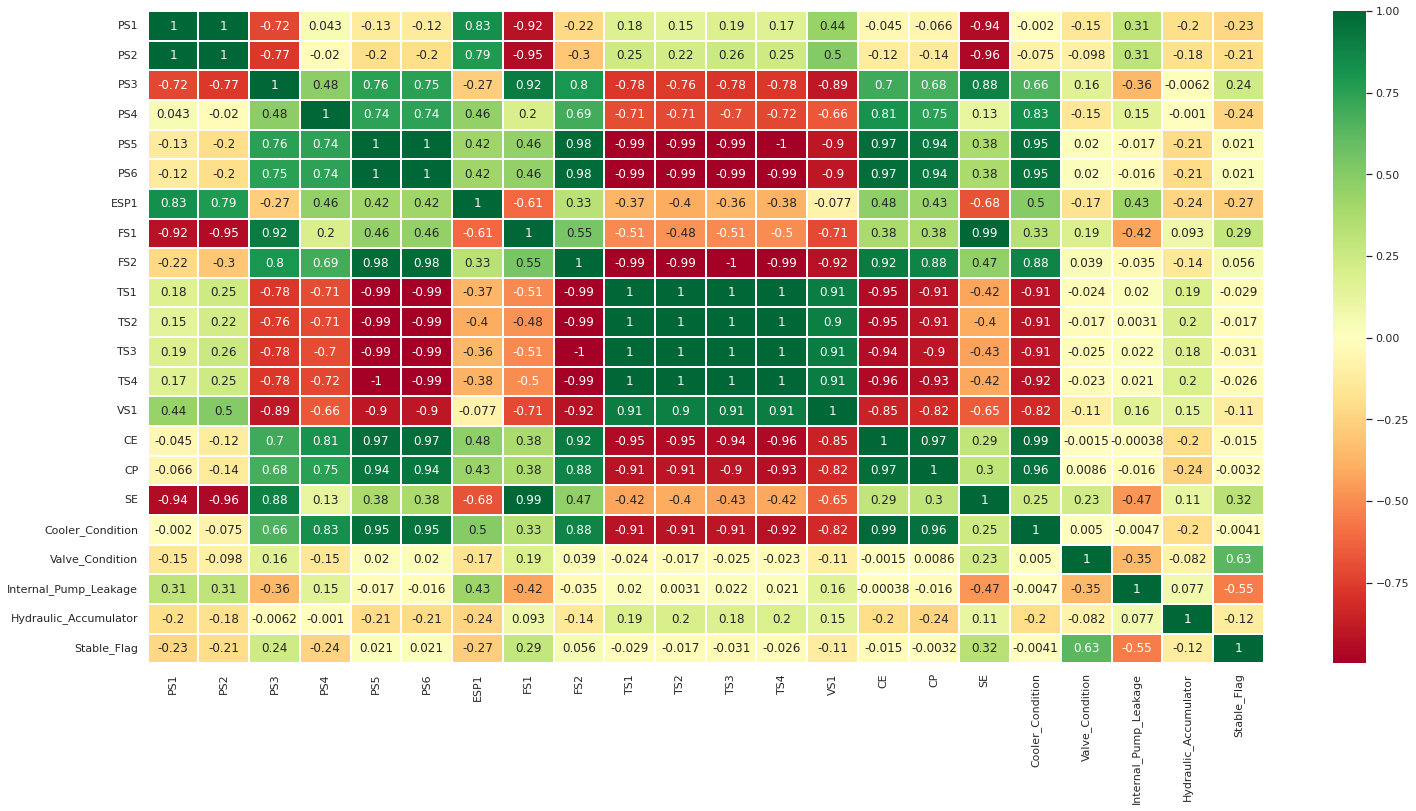

In [ ]:
#Correlation base Heatmap
plt.figure(figsize=(25,12))
sns.heatmap(df_final.corr(), annot=True, cmap='RdYlGn', linewidths=1, cbar=True)
plt.show

In [ ]:
from collections import defaultdict
df_final.adj = {}
df_final.adj = defaultdict(list)

In [ ]:
#Target is Last 5 Columns
df_final_corr = df_final.corr().sort_values(["Cooler_Condition","Valve_Condition","Internal_Pump_Leakage","Hydraulic_Accumulator","Stable_Flag"],ascending=False)
df_final_corr_target = df_final_corr[["Cooler_Condition","Valve_Condition","Internal_Pump_Leakage","Hydraulic_Accumulator","Stable_Flag"]]
df_final_corr_target.drop(["Cooler_Condition","Valve_Condition","Internal_Pump_Leakage","Hydraulic_Accumulator","Stable_Flag"],axis=0,inplace=True)
df_final_corr_target

,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator,Stable_Flag
CE,0.991943,-0.001463,-0.000381,-0.204599,-0.015316
CP,0.956220,0.008605,-0.015806,-0.241432,-0.003231
PS6,0.950316,0.020284,-0.016262,-0.210282,0.021353
PS5,0.949962,0.020317,-0.016579,-0.209262,0.021458
FS2,0.881340,0.038651,-0.034926,-0.139471,0.055942
PS4,0.832446,-0.146385,0.154950,-0.001021,-0.244314
PS3,0.662852,0.163278,-0.355070,-0.006242,0.237027
ESP1,0.497514,-0.174618,0.426320,-0.239692,-0.267649
FS1,0.330446,0.190141,-0.421702,0.092695,0.288568
SE,0.249273,0.231354,-0.469243,0.112756,0.324695


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff32f78b950>,
      dtype=object)

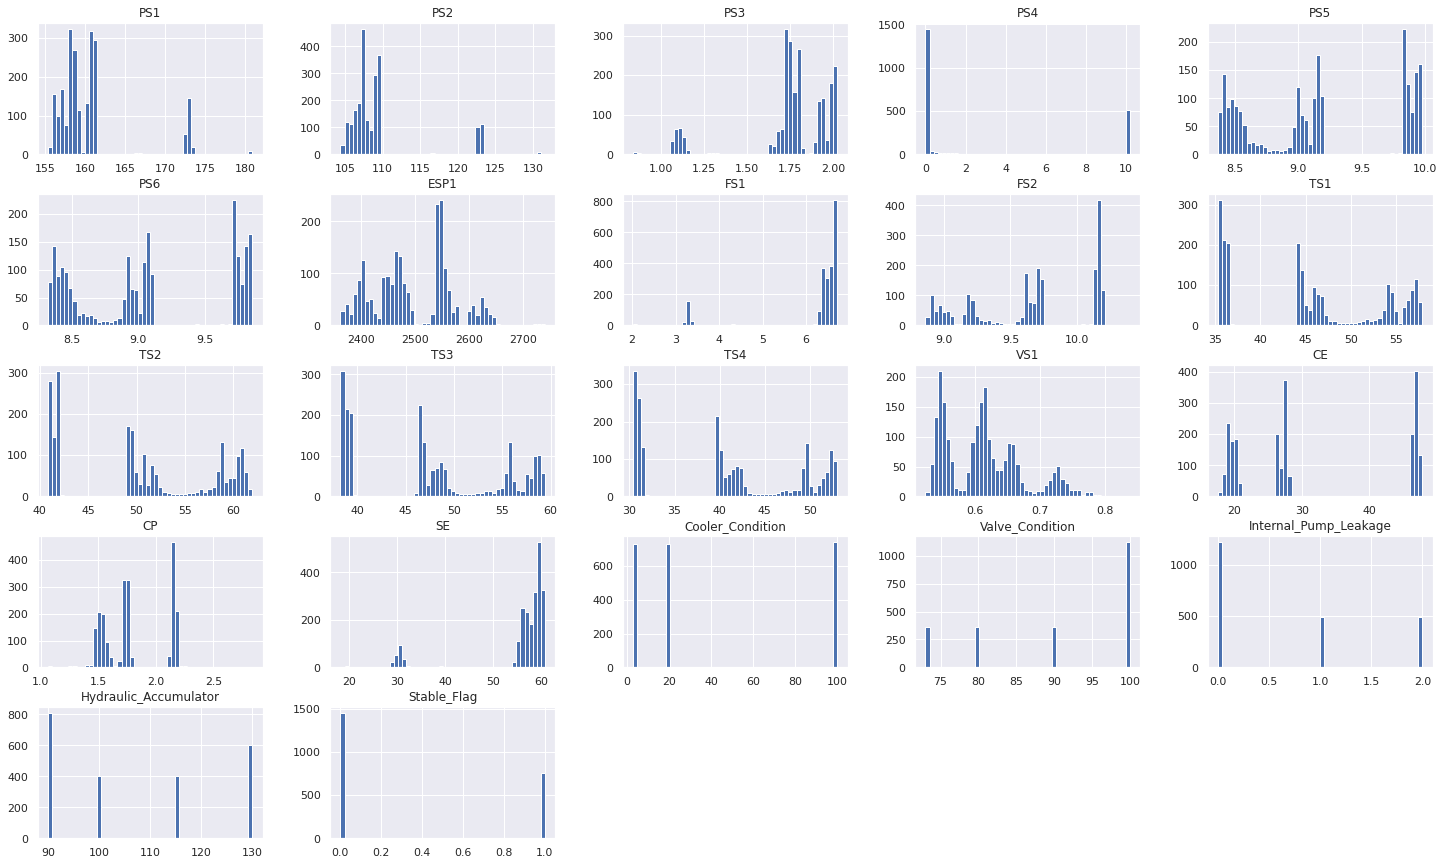

In [ ]:
df_final.hist(bins=50, figsize=(25,15), ax=None)

# 3- Data Preprocessing

In [ ]:
x = df_final.iloc[:,:-5]
y = df_final.iloc[:,-5:]
print (x.shape, y.shape)

(2205, 17) (2205, 5)


In [ ]:
target_1=y.iloc[:,-5]
target_2=y.iloc[:,-4]
target_3=y.iloc[:,-3]
target_4=y.iloc[:,-2]

final_target=y.iloc[:,-1]
final_target=(final_target.astype(int))

Reguler process

In [ ]:
# Feature SCaling
from sklearn.preprocessing import StandardScaler as scaler

x_scaler = scaler().fit_transform(x)
print(x_scaler.shape)

(2205, 17)


In [ ]:
#data split
X_train, X_test, target_1_train, target_1_test = train_test_split(x_scaler, target_1, test_size=0.2, random_state=1)
X_train.shape, X_test.shape, target_1_train.shape, target_1_test.shape

((1764, 17), (441, 17), (1764,), (441,))

In [ ]:
from sklearn import svm, metrics, preprocessing, utils
lab_enc = preprocessing.LabelEncoder()
Y_LE= lab_enc.fit_transform(target_1_train)
Y_TE= lab_enc.fit_transform(target_1_test)
print(Y_LE, Y_TE)
len(Y_LE), len(Y_TE)

[0 0 2 ... 1 0 1] [1 0 0 2 1 0 1 1 2 2 0 2 2 1 1 1 0 0 2 0 2 0 2 0 1 2 0 0 2 1 0 2 0 2 0 1 1
 0 0 0 1 2 2 2 0 0 0 0 0 0 2 0 1 1 2 1 2 1 1 1 0 1 0 0 2 1 0 1 0 2 1 0 0 1
 1 1 2 2 2 0 2 2 0 1 2 2 2 0 0 2 2 1 0 0 1 1 0 1 0 1 0 0 2 2 0 0 0 1 0 2 1
 2 2 1 0 0 2 1 1 1 1 0 1 1 2 0 1 2 2 2 0 2 1 1 1 2 2 1 2 0 1 0 2 2 0 0 2 1
 2 2 1 1 2 0 1 0 1 1 1 0 1 0 2 0 0 2 1 0 1 0 0 0 2 1 0 1 0 2 1 2 1 1 2 0 1
 2 0 0 0 0 2 2 1 1 0 1 0 0 1 1 1 2 2 0 1 2 1 1 0 1 2 0 1 2 2 1 2 0 0 0 2 2
 2 0 2 1 1 0 0 0 2 1 0 1 0 0 1 0 2 2 2 1 2 2 0 0 1 0 1 0 2 0 0 2 2 1 0 2 1
 2 1 2 1 2 1 0 0 0 0 1 1 2 2 2 2 1 2 1 1 1 1 2 2 0 1 2 1 0 1 1 1 2 0 1 0 0
 1 0 1 1 2 1 2 1 2 1 0 1 0 2 1 1 1 0 1 0 0 2 1 2 0 2 2 1 0 2 1 0 0 2 0 1 0
 2 1 2 2 0 2 1 1 0 0 2 1 2 1 1 1 2 0 1 2 2 0 2 0 2 1 1 2 2 0 1 2 1 0 2 2 1
 1 1 1 2 2 0 1 2 1 1 1 2 1 1 0 1 0 1 0 2 0 2 0 2 2 1 0 1 1 0 2 1 1 2 1 1 2
 0 1 0 1 2 1 1 2 2 0 0 0 1 1 0 0 0 0 2 1 1 2 0 1 2 0 1 2 0 0 0 2 2 2]


(1764, 441)

r2 score SVM : = 1.0
accuracy= 1.0


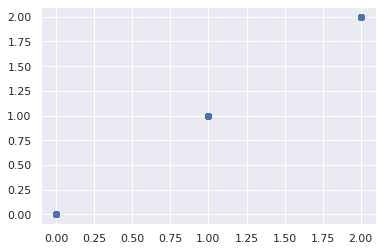

In [ ]:
# SVM algorithm
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train, Y_LE)
y_pred_SVM = model.predict(X_test)
print("r2 score SVM : = " + str(r2_score(y_pred_SVM, Y_TE)))
print('accuracy= '+ str(accuracy_score(y_pred_SVM, Y_TE)))
plt.scatter(y_pred_SVM, Y_TE)

r2 Score xgb : = 1.0
accuracy= 1.0


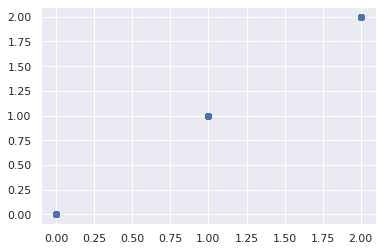

In [ ]:
#Xgboost classifier
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, Y_LE)
y_pred_xgb = model.predict(X_test)
print("r2 Score xgb : = " + str(r2_score(y_pred_xgb, Y_TE)))
print('accuracy= '+ str(accuracy_score(y_pred_SVM,Y_TE)))
plt.scatter(y_pred_xgb, Y_TE)

## Target 1

In [ ]:
round((target_1.value_counts(normalize=True)), 4)

100.0    0.3361
3.0      0.3320
20.0     0.3320
Name: Cooler_Condition, dtype: float64

In [ ]:
train_x,test_x,train_y,test_y=train_test_split(x,target_1,test_size=0.2,random_state=1)
train_x.shape,test_x.shape,train_y.shape,test_y.shape

((1764, 17), (441, 17), (1764,), (441,))

In [ ]:
sc=StandardScaler()
train_x=sc.fit_transform(train_x)
test_x=sc.transform(test_x)
train_x.shape, test_x.shape

((1764, 17), (441, 17))

# Models (classification)    target-1

In [ ]:
tpotc=TPOTClassifier(generations=20,population_size=50,scoring=["accuracy","precision"],cv=5,verbosity=2,n_jobs=-1,random_state=42,config_dict="TPOT light")

tpotc.fit(train_x,train_y)

tpotc.fitted_pipeline_

Optimization Progress:   0%|          | 0/1050 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9988668555240793

Generation 2 - Current best internal CV score: 0.9988668555240793

Generation 3 - Current best internal CV score: 0.9988668555240793

Generation 4 - Current best internal CV score: 0.9988668555240793

Generation 5 - Current best internal CV score: 0.9988668555240793

Generation 6 - Current best internal CV score: 0.9988668555240793

Generation 7 - Current best internal CV score: 0.9988668555240793

Generation 8 - Current best internal CV score: 0.9988668555240793

Generation 9 - Current best internal CV score: 0.9988668555240793

Generation 10 - Current best internal CV score: 0.9988668555240793

Generation 11 - Current best internal CV score: 0.9988668555240793

Generation 12 - Current best internal CV score: 0.9988668555240793

Generation 13 - Current best internal CV score: 0.9988668555240793

Generation 14 - Current best internal CV score: 0.9988668555240793

Generation 15 - Current best internal CV score: 0.998866

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=2, min_samples_leaf=12,
                                        min_samples_split=7,
                                        random_state=42))])

accuracy_score_tpotc_train=  0.9988662131519275
accuracy_score_tpotc_test=  1.0

confusion_matrix:-


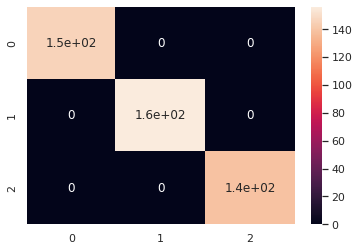

In [ ]:
pred_train_y=tpotc.predict(train_x)
pred_test_y=tpotc.predict(test_x)
accuracy_score_tpotc_train=accuracy_score(train_y,pred_train_y)
accuracy_score_tpotc_test=accuracy_score(test_y,pred_test_y)
print("accuracy_score_tpotc_train= ",accuracy_score_tpotc_train)
print("accuracy_score_tpotc_test= ",accuracy_score_tpotc_test)
print("\nconfusion_matrix:-")
sns.heatmap(confusion_matrix(test_y,pred_test_y),annot=True)

In [ ]:
precision_score_tpotc_train=precision_score(train_y,pred_train_y,average="weighted")
precision_score_tpotc_test=precision_score(test_y,pred_test_y,average="weighted")
print("precision_score_tpotc_train= ",precision_score_tpotc_train)
print("precision_score_tpotc_test= ",precision_score_tpotc_test)

precision_score_tpotc_train=  0.99887013628981
precision_score_tpotc_test=  1.0


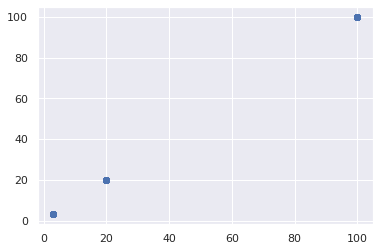

In [ ]:
plt.scatter(test_y,pred_test_y)

### cross validate

In [ ]:
scores=cross_validate(tpotc,train_x,train_y,scoring=["accuracy","precision_weighted"],cv=5)
scores

Optimization Progress:   0%|          | 0/1050 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9992932862190813

Generation 2 - Current best internal CV score: 0.9992932862190813

Generation 3 - Current best internal CV score: 0.9992932862190813

Generation 4 - Current best internal CV score: 0.9992932862190813

Generation 5 - Current best internal CV score: 0.9992932862190813

Generation 6 - Current best internal CV score: 0.9992932862190813

Generation 7 - Current best internal CV score: 0.9992932862190813

Generation 8 - Current best internal CV score: 0.9992932862190813

Generation 9 - Current best internal CV score: 0.9992932862190813

Generation 10 - Current best internal CV score: 0.9992932862190813

Generation 11 - Current best internal CV score: 0.9992932862190813

Generation 12 - Current best internal CV score: 0.9992932862190813

Generation 13 - Current best internal CV score: 0.9992932862190813

Generation 14 - Current best internal CV score: 0.9992932862190813

Generation 15 - Current best internal CV score: 0.999293

Optimization Progress:   0%|          | 0/1050 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9992932862190813

Generation 2 - Current best internal CV score: 0.9992932862190813

Generation 3 - Current best internal CV score: 0.9992932862190813

Generation 4 - Current best internal CV score: 0.9992932862190813

Generation 5 - Current best internal CV score: 0.9992932862190813

Generation 6 - Current best internal CV score: 0.9992932862190813

Generation 7 - Current best internal CV score: 0.9992932862190813

Generation 8 - Current best internal CV score: 0.9992932862190813

Generation 9 - Current best internal CV score: 0.9992932862190813

Generation 10 - Current best internal CV score: 0.9992932862190813

Generation 11 - Current best internal CV score: 0.9992932862190813

Generation 12 - Current best internal CV score: 0.9992932862190813

Generation 13 - Current best internal CV score: 0.9992932862190813

Generation 14 - Current best internal CV score: 0.9992932862190813

Generation 15 - Current best internal CV score: 0.999293

Optimization Progress:   0%|          | 0/1050 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9985840663609252

Generation 2 - Current best internal CV score: 0.9985840663609252

Generation 3 - Current best internal CV score: 0.9985840663609252

Generation 4 - Current best internal CV score: 0.9985840663609252

Generation 5 - Current best internal CV score: 0.9985840663609252

Generation 6 - Current best internal CV score: 0.9985840663609252

Generation 7 - Current best internal CV score: 0.9985840663609252

Generation 8 - Current best internal CV score: 0.9985840663609252

Generation 9 - Current best internal CV score: 0.9985840663609252

Generation 10 - Current best internal CV score: 0.9985840663609252

Generation 11 - Current best internal CV score: 0.9985840663609252

Generation 12 - Current best internal CV score: 0.9985840663609252

Generation 13 - Current best internal CV score: 0.9985840663609252

Generation 14 - Current best internal CV score: 0.9985840663609252

Generation 15 - Current best internal CV score: 0.998584

Optimization Progress:   0%|          | 0/1050 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9985840663609252

Generation 2 - Current best internal CV score: 0.9985840663609252

Generation 3 - Current best internal CV score: 0.9985840663609252

Generation 4 - Current best internal CV score: 0.9985840663609252

Generation 5 - Current best internal CV score: 0.9992932862190813

Generation 6 - Current best internal CV score: 0.9992932862190813

Generation 7 - Current best internal CV score: 0.9992932862190813

Generation 8 - Current best internal CV score: 0.9992932862190813

Generation 9 - Current best internal CV score: 0.9992932862190813

Generation 10 - Current best internal CV score: 0.9992932862190813

Generation 11 - Current best internal CV score: 0.9992932862190813

Generation 12 - Current best internal CV score: 0.9992932862190813

Generation 13 - Current best internal CV score: 0.9992932862190813

Generation 14 - Current best internal CV score: 0.9992932862190813

Generation 15 - Current best internal CV score: 0.999293

Optimization Progress:   0%|          | 0/1050 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9985865724381625

Generation 2 - Current best internal CV score: 0.9985865724381625

Generation 3 - Current best internal CV score: 0.9985865724381625

Generation 4 - Current best internal CV score: 0.9985865724381625

Generation 5 - Current best internal CV score: 0.9985865724381625

Generation 6 - Current best internal CV score: 0.9985865724381625

Generation 7 - Current best internal CV score: 0.9985865724381625

Generation 8 - Current best internal CV score: 0.9992932862190813

Generation 9 - Current best internal CV score: 0.9992932862190813

Generation 10 - Current best internal CV score: 0.9992932862190813

Generation 11 - Current best internal CV score: 0.9992932862190813

Generation 12 - Current best internal CV score: 0.9992932862190813

Generation 13 - Current best internal CV score: 0.9992932862190813

Generation 14 - Current best internal CV score: 0.9992932862190813

Generation 15 - Current best internal CV score: 0.999293

{'fit_time': array([66.99294186, 70.02153754, 67.02067423, 74.26496363, 70.85023808]),
 'score_time': array([0.0022552 , 0.00376272, 0.00200891, 0.00226283, 0.02896762]),
 'test_accuracy': array([0.99716714, 0.99716714, 1.        , 0.99716714, 0.99715909]),
 'test_precision_weighted': array([0.99719055, 0.99719199, 1.        , 0.99719266, 0.99718277])}

In [ ]:
print("tpot_accuracy_score_target1= ",scores["test_accuracy"].mean())
print("tpot_precision_score_target1= ",scores["test_precision_weighted"].mean())

tpot_accuracy_score_target1=  0.997732101467937
tpot_precision_score_target1=  0.9977515929179196


## Target 2

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(x,target_2,test_size=0.2,random_state=1)

In [ ]:
sc=StandardScaler()
train_x=sc.fit_transform(train_x)
test_x=sc.transform(test_x)

# Models (classifiers)     target-2

In [ ]:
tpotc=TPOTClassifier(generations=20,population_size=50,scoring=["accuracy","precision"],cv=5,
                    random_state=2,verbosity=2,config_dict="TPOT light",n_jobs=-1)

In [ ]:
tpotc.fit(train_x,train_y)

Optimization Progress:   0%|          | 0/1050 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9382130440381149

Generation 2 - Current best internal CV score: 0.9382130440381149

Generation 3 - Current best internal CV score: 0.9382130440381149

Generation 4 - Current best internal CV score: 0.9382130440381149

Generation 5 - Current best internal CV score: 0.9382130440381149

Generation 6 - Current best internal CV score: 0.9382130440381149

Generation 7 - Current best internal CV score: 0.9852530260108164

Generation 8 - Current best internal CV score: 0.9852530260108164

Generation 9 - Current best internal CV score: 0.9852530260108164

Generation 10 - Current best internal CV score: 0.9852530260108164

Generation 11 - Current best internal CV score: 0.9852530260108164

Generation 12 - Current best internal CV score: 0.9875321916044296

Generation 13 - Current best internal CV score: 0.9875321916044296

Generation 14 - Current best internal CV score: 0.9937612670615502

Generation 15 - Current best internal CV score: 0.993761

TPOTClassifier(config_dict='TPOT light', generations=20, n_jobs=-1,
               population_size=50, random_state=2,
               scoring=['accuracy', 'precision'], verbosity=2)

accuracy_score_tpotc_train=  0.9954648526077098
accuracy_score_tpotc_test=  0.9909297052154195

confusion_matrix:-


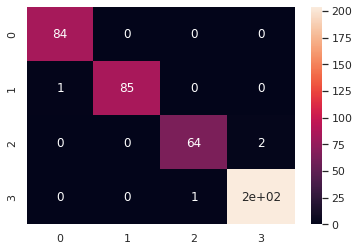

In [ ]:
pred_train_y=tpotc.predict(train_x)
pred_test_y=tpotc.predict(test_x)
accuracy_score_tpotc_train=accuracy_score(train_y,pred_train_y)
accuracy_score_tpotc_test=accuracy_score(test_y,pred_test_y)
print("accuracy_score_tpotc_train= ",accuracy_score_tpotc_train)
print("accuracy_score_tpotc_test= ",accuracy_score_tpotc_test)
print("\nconfusion_matrix:-")
sns.heatmap(confusion_matrix(test_y,pred_test_y),annot=True)

In [ ]:
precision_score_tpotc_train=precision_score(train_y,pred_train_y,average="weighted")
precision_score_tpotc_test=precision_score(test_y,pred_test_y,average="weighted")
print("precision_score_tpotc_train= ",precision_score_tpotc_train)
print("precision_score_tpotc_test= ",precision_score_tpotc_test)

precision_score_tpotc_train=  0.9954789389896767
precision_score_tpotc_test=  0.9909435120824531


In [ ]:
target2_pred_values=tpotc.predict(test_x)

## Target 3

In [ ]:
round((target_3.value_counts(normalize=True)),4)  #pump's condition is also good

0.0    0.5537
2.0    0.2231
1.0    0.2231
Name: Internal_Pump_Leakage, dtype: float64

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(x,target_3,test_size=0.2,random_state=1)

In [ ]:
sc=StandardScaler()
train_x=sc.fit_transform(train_x)
test_x=sc.transform(test_x)

# Models (classification)   target-3

In [ ]:
l_classifier = LogisticRegression(random_state=42)

In [ ]:
l_classifier.fit(train_x,train_y)

LogisticRegression(random_state=42)

accuracy_score_lr_train=  0.9880952380952381
accuracy_score_lr_test=  0.9886621315192744

confusion_matrix:-


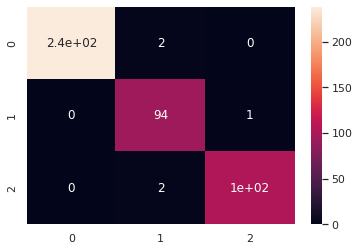

In [ ]:
pred_train_y=l_classifier.predict(train_x)
pred_test_y=l_classifier.predict(test_x)
accuracy_score_lr_train=accuracy_score(train_y,pred_train_y)
accuracy_score_lr_test=accuracy_score(test_y,pred_test_y)
print("accuracy_score_lr_train= ",accuracy_score_lr_train)
print("accuracy_score_lr_test= ",accuracy_score_lr_test)
print("\nconfusion_matrix:-")
sns.heatmap(confusion_matrix(test_y,pred_test_y),annot=True)

In [ ]:
precision_score_lr_train=precision_score(train_y,pred_train_y,average="weighted")
precision_score_lr_test=precision_score(test_y,pred_test_y,average="weighted")
print("precision_score_lr_train= ",precision_score_lr_train)
print("precision_score_lr_test= ",precision_score_lr_test)

precision_score_lr_train=  0.9882234932040569
precision_score_lr_test=  0.9889181976645534


### cross-validate

In [ ]:
scores=cross_validate(l_classifier,train_x,train_y,scoring=["accuracy","precision_weighted"],cv=10)
scores

{'fit_time': array([0.09539342, 0.09063816, 0.08307958, 0.08466792, 0.07953715,
        0.09483433, 0.07868171, 0.08285332, 0.08645701, 0.0868268 ]),
 'score_time': array([0.00178528, 0.00166559, 0.00170302, 0.00164461, 0.00165582,
        0.0017128 , 0.00170088, 0.00164437, 0.00168777, 0.00170517]),
 'test_accuracy': array([0.98305085, 0.97175141, 0.98870056, 0.98870056, 0.98295455,
        0.98863636, 0.98863636, 1.        , 0.97727273, 0.98295455]),
 'test_precision_weighted': array([0.98346769, 0.97186745, 0.98884181, 0.98884181, 0.98417208,
        0.98919069, 0.98920455, 1.        , 0.97808442, 0.98323171])}

In [ ]:
accuracy_score_lr_cross=scores["test_accuracy"].mean()
print("accuracy_score_lr_cross= ",accuracy_score_lr_cross)
precision_score_lr_cross=scores["test_precision_weighted"].mean()
print("precision_score_lr_cross= ",precision_score_lr_cross)

accuracy_score_lr_cross=  0.9852657935285054
precision_score_lr_cross=  0.9856902188670971


In [ ]:
target3_pred_values=l_classifier.predict(test_x)

## Target 4

In [ ]:
round((target_4.value_counts(normalize=True)),4)     #hydraulic accumulator's condition is not good

90.0     0.3664
130.0    0.2717
115.0    0.1810
100.0    0.1810
Name: Hydraulic_Accumulator, dtype: float64

In [ ]:
train_x,test_x,train_y,test_y=train_test_split(x,target_4,test_size=0.2,random_state=1)

In [ ]:
sc=StandardScaler()
train_x=sc.fit_transform(train_x)
test_x=sc.transform(test_x)

accuracy_score_knn_train=  0.9563492063492064
accuracy_score_knn_test=  0.9455782312925171

confusion_matrix:-


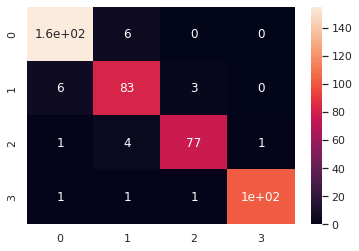

In [ ]:
knn=KNeighborsClassifier(n_neighbors=5,p=2)
knn.fit(train_x,train_y)

pred_train_y=knn.predict(train_x)
pred_test_y=knn.predict(test_x)
accuracy_score_knn_train=accuracy_score(train_y,pred_train_y)
accuracy_score_knn_test=accuracy_score(test_y,pred_test_y)
print("accuracy_score_knn_train= ",accuracy_score_knn_train)
print("accuracy_score_knn_test= ",accuracy_score_knn_test)
print("\nconfusion_matrix:-")
sns.heatmap(confusion_matrix(test_y,pred_test_y),annot=True)

In [ ]:
precision_score_knn_train=precision_score(train_y,pred_train_y,average="weighted")
precision_score_knn_test=precision_score(test_y,pred_test_y,average="weighted")
print("precision_score_knn_train= ",precision_score_knn_train)
print("precision_score_knn_test= ",precision_score_knn_test)

precision_score_knn_train=  0.9563237596665205
precision_score_knn_test=  0.9460635354978844


### cross-validate

In [ ]:
scores=cross_validate(knn,train_x,train_y,scoring=["accuracy","precision_weighted"],cv=10)
scores

{'fit_time': array([0.00242376, 0.00169778, 0.0016675 , 0.00256395, 0.00169492,
        0.00169158, 0.00181484, 0.00168133, 0.00165987, 0.00171614]),
 'score_time': array([0.02328706, 0.01810431, 0.01811934, 0.01958895, 0.01797295,
        0.01766515, 0.01786208, 0.01751447, 0.01972365, 0.01844144]),
 'test_accuracy': array([0.93785311, 0.95480226, 0.92090395, 0.93785311, 0.92045455,
        0.90909091, 0.91477273, 0.93181818, 0.89204545, 0.93181818]),
 'test_precision_weighted': array([0.93992895, 0.95550847, 0.9219647 , 0.93973445, 0.91978743,
        0.91043586, 0.91970435, 0.93202459, 0.89752183, 0.93150704])}

In [ ]:
accuracy_score_knn_cross=scores["test_accuracy"].mean()
print("accuracy_score_knn_cross= ",accuracy_score_knn_cross)
precision_score_knn_cross=scores["test_precision_weighted"].mean()
print("precision_score_knn_cross= ",precision_score_knn_cross)

accuracy_score_knn_cross=  0.9251412429378532
precision_score_knn_cross=  0.9268117674239533


In [ ]:
target4_pred_values=knn.predict(test_x)

## Final Target

In [ ]:
y_ind=y.iloc[:,:-1]
y_ind.head()

,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator
0,3.0,100.0,0.0,130.0
1,3.0,100.0,0.0,130.0
2,3.0,100.0,0.0,130.0
3,3.0,100.0,0.0,130.0
4,3.0,100.0,0.0,130.0


In [ ]:
final_target.value_counts(normalize=True)
train_x,test_x,train_y,test_y=train_test_split(y_ind,final_target,test_size=0.2,random_state=1,stratify=final_target)

In [ ]:
sc=StandardScaler()
train_x=sc.fit_transform(train_x)
test_x=sc.transform(test_x)

accuracy_score_dtc_train=  0.9319727891156463
accuracy_score_dtc_test=  0.9160997732426304

confusion_matrix:-


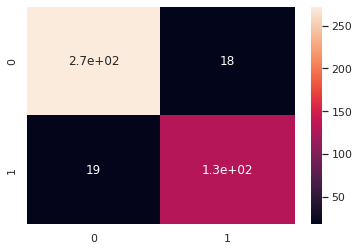

In [ ]:
dtc = DecisionTreeClassifier(criterion="entropy",random_state=1)

dtc.fit(train_x,train_y)

pred_train_y=dtc.predict(train_x)
pred_test_y=dtc.predict(test_x)
accuracy_score_dtc_train=accuracy_score(train_y,pred_train_y)
accuracy_score_dtc_test=accuracy_score(test_y,pred_test_y)
print("accuracy_score_dtc_train= ",accuracy_score_dtc_train)
print("accuracy_score_dtc_test= ",accuracy_score_dtc_test)
print("\nconfusion_matrix:-")
sns.heatmap(confusion_matrix(test_y,pred_test_y),annot=True)  

In [ ]:
precision_score_dtc_train=precision_score(train_y,pred_train_y)
precision_score_dtc_test=precision_score(test_y,pred_test_y)
print("precision_score_dtc_train= ",precision_score_dtc_train)
print("precision_score_dtc_test= ",precision_score_dtc_test)    

precision_score_dtc_train=  0.886762360446571
precision_score_dtc_test=  0.88


### cross-validate

In [ ]:
scores=cross_validate(dtc,train_x,train_y,scoring=["accuracy","precision"],cv=10)
scores

{'fit_time': array([0.00706816, 0.00177741, 0.00216126, 0.00173354, 0.00173283,
        0.00167251, 0.00175881, 0.00157666, 0.00158167, 0.00153828]),
 'score_time': array([0.00256586, 0.00151372, 0.00145054, 0.00138807, 0.00227284,
        0.00143266, 0.00136256, 0.00133705, 0.00136638, 0.00135565]),
 'test_accuracy': array([0.92090395, 0.89830508, 0.9039548 , 0.91525424, 0.9375    ,
        0.91477273, 0.92613636, 0.90340909, 0.90909091, 0.90909091]),
 'test_precision': array([0.8852459 , 0.85245902, 0.87931034, 0.83823529, 0.91525424,
        0.82608696, 0.8852459 , 0.87719298, 0.84375   , 0.85714286])}

In [ ]:
accuracy_score_dtc_cross=scores["test_accuracy"].mean()
print("accuracy_score_dtc_cross= ",accuracy_score_dtc_cross)
precision_score_dtc_cross=scores["test_precision"].mean()
print("precision_score_dtc_cross= ",precision_score_dtc_cross)

accuracy_score_dtc_cross=  0.9138418079096043
precision_score_dtc_cross=  0.8659923492026238


# Final_data for testing with final_target

In [ ]:
df_final_data_testing_final_target = pd.DataFrame({"Valve_Condition":target2_pred_values
                                                 ,"Internal_Pump_Leakage":target3_pred_values,"Hydraulic_Accumulator":target4_pred_values})
df_final_data_testing_final_target.head()

,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator
0,100.0,0.0,90.0
1,73.0,1.0,90.0
2,80.0,0.0,115.0
3,100.0,0.0,90.0
4,90.0,2.0,90.0
